In [721]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import lightgbm as lgb
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import datetime
from scipy.stats import boxcox
import h2o
import scipy.optimize as opt

# import h2o

# from h2o.automl import H2OAutoML
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space
import os
from autogluon.tabular import TabularDataset, TabularPredictor

In [1470]:
data = pd.read_csv("../data/processed/data.csv", parse_dates=["date_forecast", "date_calc"])
data_catboost = pd.read_csv("../data/processed/data_catboost.csv", parse_dates=["date_forecast", "date_calc"])
data_no_resample = pd.read_csv("../data/processed/data_no_resample.csv", parse_dates=["date_forecast", "date_calc"])
data_catboost_no_resample = pd.read_csv("../data/processed/data_catboost_no_resample.csv", parse_dates=["date_forecast", "date_calc"])

# Modeling Notebook


Each model returns is trained on a subset of the data. The models are then combined into a voting classifier. The voting classifier is then used to predict the test data.


In [659]:
result = {}
test_result = {}
ensamble_holdout = {}

In [660]:
def scale_data(data, cols=None):
    if cols is None:
        ignore_cols = [
            "location",
            "dew_or_rime:idx",
            "is_day:idx",
            "is_in_shadow:idx",
            "pv_measurement",
            "data_type",
        ]

        cols = [col for col in data.columns if col not in ignore_cols]

    X_scaler = MinMaxScaler()
    X_scaler = X_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][cols]
    )
    y_scaler = MinMaxScaler()
    y_scaler = y_scaler.fit(
        data[data["data_type"].isin(["observed", "estimated"])][["pv_measurement"]]
    )

    data_copy = data.copy()

    data_copy[cols] = X_scaler.transform(data_copy[cols])
    data_copy[["pv_measurement"]] = y_scaler.transform(data[["pv_measurement"]])

    return data_copy, X_scaler, y_scaler

## 1. General Model – LightGBM


### Feature Engineering and Selection


In [1406]:
data_catboost.columns

Index(['location', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_spee

In [1461]:
data_general_lgb = data_catboost.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    # "hour",
    # "month",
    "month_sin",
    "hour_sin",
    "month_cos",
    "hour_cos",
    "date_calc",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    # "sun_azimuth:d",
    "date_forecast",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    # "total_cloud_cover:p",
    # "effective_cloud_cover:p"
    # "diffuse_rad:W",
]

weights_data = data_general_lgb[
    data_general_lgb.data_type.isin(
        ["observed", "estimated"]
    )
].copy()

weights = (
    np.where(
        weights_data.date_forecast > "2020-04",
        1,
        0,
    ),
)[0]

data_general_lgb = data_general_lgb.drop(drop_cols, axis=1)
data_general_lgb.columns = [
    column.replace(":", "_") for column in data_general_lgb.columns
]

ignore_cols = [
    "location",
    "is_day_idx",
    "is_in_shadow_idx",
    "pv_measurement",
    "data_type",
]

data_general_lgb["is_day_idx"] = data_general_lgb["is_day_idx"].astype("int")
data_general_lgb["is_in_shadow_idx"] = data_general_lgb["is_in_shadow_idx"].astype("int")
data_general_lgb["dew_or_rime_idx"] = data_general_lgb["dew_or_rime_idx"].astype("int")

cols = [col for col in data_general_lgb.columns if col not in ignore_cols]

data_general_lgb, _, y_scaler = scale_data(data_general_lgb, cols=cols)

# location one-hot

data_general_lgb = pd.get_dummies(data_general_lgb, columns=["location"])

# Create training and test data
test = data_general_lgb[data_general_lgb["data_type"].isin(["test"])].drop(columns=["data_type"]).copy()
train = data_general_lgb[data_general_lgb["data_type"].isin(["observed", "estimated"])].drop(columns=["data_type"]).copy()


### Model Setup


In [1462]:
# ---------------------------------------- LIGHTGBM ----------------------------------------

pv_measurement = train["pv_measurement"]

# Define the number of folds
n_splits = 10  # You can change this as needed

# Create a KFold splitter
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

model_params = {
    "metric": "MSE",
    "max_depth": 6,
    "num_rounds": 200,
    # "feature_fraction": 0.4724632038687269,
    "colsample_bytree": 0.6,
    "learning_rate": 0.04,
    "num_leaves": 140,
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Loop through the K-fold splits
for i, (train_index, val_index) in enumerate(kf.split(train)):
    print(f"Fold {i + 1}/{n_splits}")
    # Split the data into training and validation sets
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
    pv_measurement_train, pv_measurement_val = (
        pv_measurement.iloc[train_index],
        pv_measurement.iloc[val_index],
    )

    # Create a CatBoostRegressor instance for this fold
    model = lgb.LGBMRegressor(**model_params)

    # Fit the model
    model.fit(
        train_fold.drop(columns=["pv_measurement"]),
        pv_measurement_train,
        # sample_weight=weights[train_index]
    )

    # Get predictions for the validation set
    preds = model.predict(val_fold.drop(columns=["pv_measurement"]))

    # Invert scaling for the validation set predictions
    prediction_scaled = y_scaler.inverse_transform(preds.reshape(-1, 1))
    prediction_df_scaled = pd.DataFrame(prediction_scaled, index=val_index)

    # Append the predictions to the list
    all_preds = pd.concat([all_preds, prediction_df_scaled], axis=0)

    # Get predictions for the test set
    preds_test = model.predict(test.drop(columns=["pv_measurement"]))

    # Invert scaling for the test set predictions
    prediction_scaled_test = y_scaler.inverse_transform(preds_test.reshape(-1, 1))
    prediction_df_scaled_test = pd.DataFrame(prediction_scaled_test)

    # Append the predictions to the list
    temp_test_result.append(prediction_df_scaled_test)

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = lgb.LGBMRegressor(**model_params)

# Fit the model
model.fit(train.drop(columns=["pv_measurement"]), pv_measurement)

# Get predictions for the validation set
preds = model.predict(test.drop(columns=["pv_measurement"]))

Fold 1/10


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200
Fold 2/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 6/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 7/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 8/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 9/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 10/10
[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=200, num_rounds=200 will be ignored. Current value: num_iterations=200


### Model Result


In [1463]:
result["general_lightgbm"] = all_preds.sort_index()[0]
test_result["general_lightgbm"] = pd.DataFrame(y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"])

## 1. General Model – CatBoost (with target transformation) TODO

In [ ]:
data_general_catboost_target_transformation = data.copy()

# Create training and test data
train = data_general_catboost_target_transformation[
    data_general_catboost_target_transformation["data_type"].isin(
        ["observed", "estimated"]
    )
].copy()

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "data_type",
    "sun_azimuth:d",
]

train = train.drop(drop_cols, axis=1)


# Transforming the target value to extract some kind of seasonality

### Model Result


## 1. General Model - CatBoost (best recreated)

### Feature Engineering and Selection

In [661]:
data_general_catboost_best_recreated = data_catboost.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    #"sun_azimuth:d",
]
data_general_catboost_best_recreated = data_general_catboost_best_recreated.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_best_recreated.columns if col not in ignore_cols]

data_general_catboost_best_recreated, _, y_scaler = scale_data(data_general_catboost_best_recreated, cols=cols)

# Create training and test data
train = (
    data_general_catboost_best_recreated[
        data_general_catboost_best_recreated["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_best_recreated[data_general_catboost_best_recreated["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)
holdout = (
    data_general_catboost_best_recreated[data_general_catboost_best_recreated["data_type"] == "estimated"]
    .drop(columns=["data_type"])
    .tail(24*3*10)
    .copy()
)

### Model Setup

In [662]:
# ---------------------------------------- CATBOOST ----------------------------------------

cat_features = [0]
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE", cat_features=cat_features)


pv_measurement = train["pv_measurement"]
train.drop("pv_measurement", axis=1, inplace=True)

# Define the number of folds
n_splits = 20  # You can change this as needed

# Create a KFold splitter
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Loop through the K-fold splits
for i, (train_index, val_index) in enumerate(kf.split(train)):
    print(f"Fold {i + 1}/{n_splits}")
    # Split the data into training and validation sets
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
    pv_measurement_train, pv_measurement_val = pv_measurement.iloc[train_index], pv_measurement.iloc[val_index]

    # Create a CatBoostRegressor instance for this fold
    model = catboost.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_fold, pv_measurement_train)

    # Get predictions for the validation set
    preds = model.predict(val_fold)

    # Invert scaling for the validation set predictions
    prediction_scaled = y_scaler.inverse_transform(preds.reshape(-1, 1))
    prediction_df_scaled = pd.DataFrame(prediction_scaled, index=val_fold.index)

    # Append the predictions to the list
    all_preds = pd.concat([all_preds, prediction_df_scaled], axis=0)

    # Get predictions for the test set
    preds_test = model.predict(test)

    # Invert scaling for the test set predictions
    prediction_scaled_test = y_scaler.inverse_transform(preds_test.reshape(-1, 1))
    prediction_df_scaled_test = pd.DataFrame(prediction_scaled_test)

    # Append the predictions to the list
    temp_test_result.append(prediction_df_scaled_test)

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = catboost.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train, pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

Fold 1/20
0:	learn: 0.0496941	total: 56ms	remaining: 55.9s
1:	learn: 0.0486512	total: 101ms	remaining: 50.5s
2:	learn: 0.0476484	total: 147ms	remaining: 48.9s
3:	learn: 0.0465627	total: 201ms	remaining: 50s
4:	learn: 0.0456283	total: 248ms	remaining: 49.4s
5:	learn: 0.0445796	total: 292ms	remaining: 48.4s
6:	learn: 0.0434861	total: 341ms	remaining: 48.3s
7:	learn: 0.0427162	total: 396ms	remaining: 49.1s
8:	learn: 0.0419573	total: 439ms	remaining: 48.3s
9:	learn: 0.0410263	total: 477ms	remaining: 47.2s
10:	learn: 0.0402329	total: 513ms	remaining: 46.1s
11:	learn: 0.0394526	total: 552ms	remaining: 45.4s
12:	learn: 0.0385373	total: 589ms	remaining: 44.7s
13:	learn: 0.0376613	total: 637ms	remaining: 44.8s
14:	learn: 0.0368477	total: 687ms	remaining: 45.1s
15:	learn: 0.0364432	total: 747ms	remaining: 45.9s
16:	learn: 0.0356338	total: 801ms	remaining: 46.3s
17:	learn: 0.0348234	total: 862ms	remaining: 47s
18:	learn: 0.0340483	total: 917ms	remaining: 47.4s
19:	learn: 0.0333597	total: 957ms	re

### Model Result

In [663]:
result["general_catboost"] = all_preds.sort_index()[0]
test_result["general_catboost"] = pd## 1. General Model - CatBoost (best recreated)
### Feature Engineering and Selection
data_general_catboost_best_recreated = data_catboost.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    #"sun_azimuth:d",
]
data_general_catboost_best_recreated = data_general_catboost_best_recreated.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_catboost_best_recreated.columns if col not in ignore_cols]

data_general_catboost_best_recreated, _, y_scaler = scale_data(data_general_catboost_best_recreated, cols=cols)

# Create training and test data
train = (
    data_general_catboost_best_recreated[
        data_general_catboost_best_recreated["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_catboost_best_recreated[data_general_catboost_best_recreated["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)
holdout = (
    data_general_catboost_best_recreated[data_general_catboost_best_recreated["data_type"] == "estimated"]
    .drop(columns=["data_type"])
    .tail(24*3*10)
    .copy()
)
### Model Setup
# ---------------------------------------- CATBOOST ----------------------------------------

cat_features = [0]
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE", cat_features=cat_features)


pv_measurement = train["pv_measurement"]
train.drop("pv_measurement", axis=1, inplace=True)

# Define the number of folds
n_splits = 20  # You can change this as needed

# Create a KFold splitter
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Loop through the K-fold splits
for i, (train_index, val_index) in enumerate(kf.split(train)):
    print(f"Fold {i + 1}/{n_splits}")
    # Split the data into training and validation sets
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
    pv_measurement_train, pv_measurement_val = pv_measurement.iloc[train_index], pv_measurement.iloc[val_index]

    # Create a CatBoostRegressor instance for this fold
    model = catboost.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_fold, pv_measurement_train)

    # Get predictions for the validation set
    preds = model.predict(val_fold)

    # Invert scaling for the validation set predictions
    prediction_scaled = y_scaler.inverse_transform(preds.reshape(-1, 1))
    prediction_df_scaled = pd.DataFrame(prediction_scaled, index=val_fold.index)

    # Append the predictions to the list
    all_preds = pd.concat([all_preds, prediction_df_scaled], axis=0)

    # Get predictions for the test set
    preds_test = model.predict(test)

    # Invert scaling for the test set predictions
    prediction_scaled_test = y_scaler.inverse_transform(preds_test.reshape(-1, 1))
    prediction_df_scaled_test = pd.DataFrame(prediction_scaled_test)

    # Append the predictions to the list
    temp_test_result.append(prediction_df_scaled_test)

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = catboost.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train, pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)
### Model Result
result["general_catboost"] = all_preds.sort_index()[0]
test_result["general_catboost"] = pd.DataFrame(y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"]).DataFrame(y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"])

## 1. General Model - CatBoost (best recreated with estimated weighted more)

### Feature Engineering and Selection

In [1471]:
data_general_catboost_no_resample = data_catboost_no_resample.copy()


# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    # "sun_azimuth:d",
]

weights_data = data_general_catboost_no_resample[
    data_general_catboost_no_resample.data_type.isin(["observed", "estimated"])
].copy()

weights = (
    np.where(
        weights_data.data_type.isin(["estimated"]),
        1.2,
        0.8,
    ),
)[0]

data_general_catboost_no_resample = data_general_catboost_no_resample.drop(
    drop_cols, axis=1
)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [
    col for col in data_general_catboost_no_resample.columns if col not in ignore_cols
]


data_general_catboost_no_resample, _, y_scaler = scale_data(
    data_general_catboost_no_resample, cols=cols
)


# Create training and test data
train = (
    data_general_catboost_no_resample[
        data_general_catboost_no_resample["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)

test = (
    data_general_catboost_no_resample[
        data_general_catboost_no_resample["data_type"] == "test"
    ]
    .drop(columns=["data_type"])
    .copy()
)

### Model Setup

In [1473]:
# ---------------------------------------- CATBOOST ----------------------------------------

cat_features = [0]
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE", cat_features=cat_features)


pv_measurement = train["pv_measurement"]
train.drop("pv_measurement", axis=1, inplace=True)

# Define the number of folds
n_splits = 20  # You can change this as needed

# Create a KFold splitter
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cat_features = [0]
model_params = {
    "iterations": 1000,
    "depth": 9,
    "loss_function": "MAE",
    "cat_features": cat_features
}

# Initialize lists to store the predictions
all_preds = pd.DataFrame()
temp_test_result = []

# Loop through the K-fold splits
for i, (train_index, val_index) in enumerate(kf.split(train)):
    print(f"Fold {i + 1}/{n_splits}")
    # Split the data into training and validation sets
    train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]
    pv_measurement_train, pv_measurement_val = pv_measurement.iloc[train_index], pv_measurement.iloc[val_index]

    # Create a CatBoostRegressor instance for this fold
    model = catboost.CatBoostRegressor(**model_params)

    # Fit the model
    model.fit(train_fold, pv_measurement_train)

    # Get predictions for the validation set
    preds = model.predict(val_fold)

    # Invert scaling for the validation set predictions
    prediction_scaled = y_scaler.inverse_transform(preds.reshape(-1, 1))
    prediction_df_scaled = pd.DataFrame(prediction_scaled, index=val_fold.index)

    # Append the predictions to the list
    all_preds = pd.concat([all_preds, prediction_df_scaled], axis=0)

    # Get predictions for the test set
    preds_test = model.predict(test)

    # Invert scaling for the test set predictions
    prediction_scaled_test = y_scaler.inverse_transform(preds_test.reshape(-1, 1))
    prediction_df_scaled_test = pd.DataFrame(prediction_scaled_test)

    # Append the predictions to the list
    temp_test_result.append(prediction_df_scaled_test)

# For final predictions
# Create a CatBoostRegressor instance for this fold
model = catboost.CatBoostRegressor(**model_params)

# Fit the model
model.fit(train, pv_measurement)

# Get predictions for the validation set
preds = model.predict(test)

Fold 1/20
0:	learn: 0.0502664	total: 58.3ms	remaining: 58.2s
1:	learn: 0.0493942	total: 122ms	remaining: 1m 1s
2:	learn: 0.0483578	total: 182ms	remaining: 1m
3:	learn: 0.0473131	total: 223ms	remaining: 55.5s
4:	learn: 0.0461953	total: 261ms	remaining: 52s
5:	learn: 0.0452666	total: 302ms	remaining: 50s
6:	learn: 0.0442381	total: 339ms	remaining: 48.1s
7:	learn: 0.0433667	total: 385ms	remaining: 47.8s
8:	learn: 0.0424105	total: 433ms	remaining: 47.7s
9:	learn: 0.0414762	total: 471ms	remaining: 46.6s
10:	learn: 0.0407205	total: 510ms	remaining: 45.8s
11:	learn: 0.0398021	total: 547ms	remaining: 45s
12:	learn: 0.0389967	total: 583ms	remaining: 44.3s
13:	learn: 0.0382095	total: 621ms	remaining: 43.7s
14:	learn: 0.0373882	total: 655ms	remaining: 43s
15:	learn: 0.0365760	total: 693ms	remaining: 42.6s
16:	learn: 0.0357949	total: 728ms	remaining: 42.1s
17:	learn: 0.0350517	total: 760ms	remaining: 41.5s
18:	learn: 0.0342760	total: 792ms	remaining: 40.9s
19:	learn: 0.0335038	total: 820ms	remaini

### Model Results

In [1475]:
result["no_resample_catboost"] = all_preds.sort_index()[0]
test_result["no_resample_catboost"] = pd.DataFrame(y_scaler.inverse_transform(preds.reshape(-1, 1)), columns=["pv_measurement"])

## 1. General Model - XGBoost

### Feature Engineering and Selection

In [25]:
data_general_XGBoost = data.copy()

# one hot encoding the location feature
one_hot = pd.get_dummies(data_general_XGBoost["location"]).astype(int)
data_general_XGBoost = data_general_XGBoost.drop("location", axis=1)
data_general_XGBoost = pd.merge(data_general_XGBoost, one_hot, left_index=True, right_index=True)

# Drop columns that are not needed
drop_cols = [
    # "cloud_base_agl:m",
    # "ceiling_height_agl:m",
    # "snow_density:kgm3",
    "hour",
    "month",
    "date_calc",
    "date_forecast",
    "sun_azimuth:d",
]
data_general_XGBoost = data_general_XGBoost.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_general_XGBoost.columns if col not in ignore_cols]

data_general_XGBoost, _, y_scaler = scale_data(data_general_XGBoost, cols=cols)

# Create training and test data
train = (
    data_general_XGBoost[
        data_general_XGBoost["data_type"].isin(["observed", "estimated"])
    ]
    .drop(columns=["data_type"])
    .copy()
)
test = (
    data_general_XGBoost[data_general_XGBoost["data_type"] == "test"]
    .drop(columns=["data_type"])
    .copy()
)

### Model Setup

In [27]:
# ---------------------------- XGBOOST ----------------------------


# Create XGBoost model
model = xgb.XGBRegressor(
    max_depth=7,
    colsample_bytree=0.8,
    eta=0.1,
    n_estimators=90,
    reg_alpha=0.01,
    reg_lambda=0.01
)


# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=42)

result["general_XGBoost"] = pd.DataFrame()

temp_test_result = []
temp_test_indices = []

# Perform k-fold cross-validation
for train_index, validation_index in kFold.split(train):
    print(f"Train Index: {train_index}, Validation Index: {validation_index}")

    fold_train, fold_validation = train.iloc[train_index], train.iloc[validation_index]

    # Fit the XGBoost model on the training data
    model.fit(fold_train.drop("pv_measurement", axis=1), fold_train["pv_measurement"], verbose=False, eval_metric="mae")

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(model.predict(fold_validation).reshape(-1, 1))

    # Make predictions on the validation data
    predictions = y_scaler.inverse_transform(model.predict(pool_validation).reshape(-1, 1))

    result["general_XGBoost"] = pd.concat(
        [result["general_XGBoost"], pd.DataFrame(predictions, index=validation_index)], axis=0
    )

    # Make prediction on the test data
    temp_test_result.append(y_scaler.inverse_transform(model.predict(test).reshape(-1, 1)))

    

test_result["general_XGBoost"] = pd.DataFrame(np.mean(temp_test_result, axis=0), index=test.index)
result["general_XGBoost"] = result["general_XGBoost"].sort_index()

Train Index: [    0     1     2 ... 83042 83043 83044], Validation Index: [   24    35    39 ... 83032 83033 83041]


TypeError: XGBModel.fit() got an unexpected keyword argument 'enable_categorical'

### Model Result

In [ ]:
mean_absolute_error(result["general_XGBoost"][0].sort_index(), train["pv_measurement"].sort_index())

## 2. Summer Model

### Feature Engineering and Selection


In [129]:
# Dropping not important and winter features in train_summer

drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    # "dew_or_rime:idx",
    # "dew_point_2m:K",
    "fresh_snow_12h:cm",
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2",
    # "super_cooled_liquid_water:kgm2",
    "date_calc",
    "date_forecast",
    # "data_type",
    "hour",
    "month",
    "sun_azimuth:d",
]

# dropping
train_summer = train_summer.drop(drop_cols, axis=1)
test_summer = test_summer.drop(drop_cols, axis=1)

# converting is_day:ix and is_in_shadow:ix to integer
train_summer["is_day:idx"] = train_summer["is_day:idx"].astype(int)
train_summer["is_in_shadow:idx"] = train_summer["is_in_shadow:idx"].astype(int)

In [130]:
# Define the number of folds for cross-validation and whether to shuffle the data
n_folds = 5
shuffle = True

# Create the CatBoost model
model = catboost.CatBoostRegressor(iterations=1000, depth=9, loss_function="MAE")

# Create the cross-validation object
kFold = KFold(n_splits=n_folds, shuffle=shuffle, random_state=21)

result["summer_catboost"] = pd.DataFrame()

# # Perform k-fold cross-validation
for train_summer_index, validation_summer_index in kFold.split(train_summer):
    print(
        f"train_summer Index: {train_summer_index}, Validation Index: {validation_summer_index}"
    )

    fold_train_summer, fold_validation_summer = (
        train_summer.iloc[train_summer_index],
        train_summer.iloc[validation_summer_index],
    )

    pool_train_summer = catboost.Pool(
        data=fold_train_summer[
            [
                column
                for column in fold_train_summer.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_train_summer[["pv_measurement"]],
    )
    pool_validation_summer = catboost.Pool(
        data=fold_validation_summer[
            [
                column
                for column in fold_validation_summer.columns
                if not column in ["pv_measurement"]
            ]
        ],
        cat_features=["location", "is_day:idx", "is_in_shadow:idx", "data_type"],
        label=fold_validation_summer[["pv_measurement"]],
    )

    # Fit the CatBoost model on the train_summer data
    model.fit(
        pool_train_summer,
        verbose=False,
    )

    # Make predictions on the validation data
    predictions = model.predict(pool_validation_summer)

    result["summer_catboost"] = pd.concat(
        [
            result["summer_catboost"],
            pd.DataFrame(predictions, index=validation_summer_index),
        ],
        axis=0,
    )

result["summer_catboost"] = result["summer_catboost"].sort_index()
result["summer_catboost"].index = train_summer.index

train_summer Index: [    0     1     3 ... 32615 32616 32617], Validation Index: [    2     7    19 ... 32608 32612 32614]
train_summer Index: [    1     2     3 ... 32615 32616 32617], Validation Index: [    0     4    11 ... 32590 32594 32601]
train_summer Index: [    0     1     2 ... 32612 32614 32617], Validation Index: [    3    16    18 ... 32613 32615 32616]
train_summer Index: [    0     2     3 ... 32615 32616 32617], Validation Index: [    1    10    14 ... 32609 32610 32611]
train_summer Index: [    0     1     2 ... 32614 32615 32616], Validation Index: [    5     6     8 ... 32605 32607 32617]


### Model Result


In [ ]:
mean_absolute_error(
    result["summer_catboost"][0].sort_index(),
    train_summer["pv_measurement"].sort_index(),
)

In [131]:
mean_absolute_error(
    result["summer_catboost"][0].sort_index(),
    train_summer["pv_measurement"].sort_index(),
)

149.18009450339957

## Ensemble Model


In [210]:
# Define your target variable (ground truth)
# This should be a numpy array with shape (n_samples, )
target = (
    data[data.data_type.isin(["estimated", "observed"])]
    .pv_measurement.reset_index(drop=True)
    .to_numpy()
)

In [289]:
pred_data = pd.DataFrame()
for key in test_result.keys():
    if not test_result[key].empty:
        pred_data[key] = test_result[key][0]

pred_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
83045,-0.020705,0.391219,-0.567985
83046,-0.021921,-0.379679,-0.737496
83047,-0.000055,1.000165,-0.514508
83048,-0.022539,-4.722471,-0.703718
83049,-0.023199,-0.262833,-1.010278
...,...,...,...
85200,0.732188,-0.184722,-0.417115
85201,0.055493,1.989518,-1.250790
85202,7.361832,52.841269,28.951532
85203,1.503717,7.315372,3.750231


In [290]:
ensamble_data = pd.DataFrame()
for key in result.keys():
    if not result[key].empty:
        ensamble_data[key] = result[key][0]


ensamble_data

,general_catboost_mae,general_catboost_rmse,general_lightgbm
0,0.005483,-0.937258,-1.705526
1,0.000858,-0.404168,-0.490333
2,-0.004087,1.818214,0.201985
3,0.000085,3.179729,5.097704
4,0.004367,-0.371423,3.866576
...,...,...,...
83040,0.006106,0.831255,-0.087229
83041,-0.004866,-1.110484,0.012248
83042,-0.477621,5.275766,-0.289455
83043,-0.005503,-0.784950,-0.814597


In [308]:
ensamble_indices = data[
    data.data_type.isin(["observed", "estimated"])
    & data.date_forecast.dt.month.isin([5, 6, 7, 8])
].index

## H20 model based on new preproccesing and feature engineering

### Feature engineering


In [58]:
data_h2o = data.copy()

# Drop columns that are not needed
drop_cols = [
    "cloud_base_agl:m",
    "ceiling_height_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "date_calc",
    "date_forecast",
    #"sun_azimuth:d",
]

data_h2o = data_h2o.drop(drop_cols, axis=1)

ignore_cols = [
    "location",
    "dew_or_rime:idx",
    "is_day:idx",
    "is_in_shadow:idx",
    "pv_measurement",
    "data_type",
]

cols = [col for col in data_h2o.columns if col not in ignore_cols]

data_h2o, _, y_scaler = scale_data(data_h2o, cols=cols)

# Create training and test data
train = data_h2o[data_h2o["data_type"].isin(["observed", "estimated"])].copy().drop(columns=["data_type"])
test = data_h2o[data_h2o["data_type"].isin(["test"])].copy().drop(columns=["data_type"])

train = train.reset_index().drop(columns="index")


### Setup Model


In [59]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment Temurin-17.0.1+12 (build 17.0.1+12); OpenJDK 64-Bit Server VM Temurin-17.0.1+12 (build 17.0.1+12, mixed mode)
  Starting server from /Users/mathiasraa/anaconda3/envs/forecasting/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpp_mk6bg2
  JVM stdout: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpp_mk6bg2/h2o_mathiasraa_started_from_python.out
  JVM stderr: /var/folders/xd/z_ptq9v136q7kj9lf2f4sblh0000gn/T/tmpp_mk6bg2/h2o_mathiasraa_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_mathiasraa_cojdxt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [57]:
h2o.cluster().shutdown()

#### Location A

In [60]:
h2o_train = h2o.H2OFrame(train[train.location == "A"].drop(columns="location"))

h2o_model_A = h2o.automl.H2OAutoML(
    max_models=20,
    seed=1,
    stopping_metric="MAE",
    sort_metric="MAE",
    stopping_tolerance=0.01,
)

h2o_model_A.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:46:37.119: AutoML: XGBoost is not available; skipping it.

███████████████ (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_9be8604e43dc516481eccfb20aa0420a> was cancelled by the user.

In [14]:
model_path_A = h2o.save_model(model=h2o_model_A.leader, path="../models/", force=True)
print(model_path_A)


/Users/mathiasraa/Desktop/ntnu/tdt4173-forecasting/models/StackedEnsemble_AllModels_1_AutoML_1_20231029_150422


#### Location B

In [ ]:
h2o_train = h2o.H2OFrame(train[train.location == "B"].drop(columns="location"))

h2o_model_B = h2o.automl.H2OAutoML(
    max_models=20,
    seed=1,#### Location A
    stopping_metric="MAE",
    sort_metric="MAE",
    stopping_tolerance=0.01,
)

h2o_model_B.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:33:29.581: AutoML: XGBoost is not available; skipping it.
15:33:29.584: _train param, Dropping bad and constant columns: [elevation:m]


15:33:30.642: _train param, Dropping bad and constant columns: [elevation:m]

█████
15:33:41.636: _train param, Dropping bad and constant columns: [elevation:m]

███
15:34:18.926: _train param, Dropping bad and constant columns: [elevation:m]


15:34:25.343: _train param, Dropping bad and constant columns: [elevation:m]

██
15:34:32.422: _train param, Dropping bad and constant columns: [elevation:m]

██
15:34:41.532: _train param, Dropping bad and constant columns: [elevation:m]

███
15:35:30.69: _train param, Dropping bad and constant columns: [elevation:m]

█
15:35:35.508: _train param, Dropping bad and constant columns: [elevation:m]

██████████████████████████████████████████████
15:57:01.33: _train param, Dropping unused columns: [

key,value
Stacking strategy,cross_validation
Number of base models (used / total),16/20
# GBM base models (used / total),9/10
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),5/7
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [18]:
model_path_B = h2o.save_model(model=h2o_model_B.leader, path="../models/", force=True)
print(model_path_B)

/Users/mathiasraa/Desktop/ntnu/tdt4173-forecasting/models/StackedEnsemble_AllModels_1_AutoML_2_20231029_153329


#### Location C

In [ ]:
h2o_train = h2o.H2OFrame(train[train.location == "C"].drop(columns="location"))

h2o_model_C = h2o.automl.H2OAutoML(
    max_models=20,
    seed=1,
    stopping_metric="MAE",
    sort_metric="MAE",
    stopping_tolerance=0.01,
)

h2o_model_C.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
16:00:47.629: AutoML: XGBoost is not available; skipping it.
16:00:47.631: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


16:00:48.379: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█████
16:00:59.847: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
16:01:24.568: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
16:01:32.353: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
16:01:41.985: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
16:01:52.285: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
16:02:25.492: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


16:02:32.260: _train param, Dropping bad and const

key,value
Stacking strategy,cross_validation
Number of base models (used / total),14/20
# GBM base models (used / total),8/10
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),4/7
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [20]:
model_path_C = h2o.save_model(model=h2o_model_C.leader, path="../models/", force=True)
print(model_path_C)

/Users/mathiasraa/Desktop/ntnu/tdt4173-forecasting/models/StackedEnsemble_AllModels_1_AutoML_3_20231029_160047


### Results

In [23]:
h2o_test_A = h2o.H2OFrame(test[test.location == "A"].drop(columns="location"))
h2o_test_B = h2o.H2OFrame(test[test.location == "B"].drop(columns="location"))
h2o_test_C = h2o.H2OFrame(test[test.location == "C"].drop(columns="location"))


preds_A = h2o_model_A.predict(h2o_test_A)
preds_B = h2o_model_B.predict(h2o_test_B)
preds_C = h2o_model_C.predict(h2o_test_C)

preds_A = preds_A.as_data_frame().values
preds_B = preds_B.as_data_frame().values
preds_C = preds_C.as_data_frame().values

preds_A = y_scaler.inverse_transform(preds_A)
preds_B = y_scaler.inverse_transform(preds_B)
preds_C = y_scaler.inverse_transform(preds_C)

preds_A = pd.DataFrame(preds_A)
preds_B = pd.DataFrame(preds_B)
preds_C = pd.DataFrame(preds_C)

preds_A.index = test[test.location == "A"].index
preds_B.index = test[test.location == "B"].index
preds_C.index = test[test.location == "C"].index

preds_A.columns = ["pv_measurement"]
preds_B.columns = ["pv_measurement"]
preds_C.columns = ["pv_measurement"]

test_result["h2o_automl"] = pd.concat([preds_A, preds_B, preds_C], axis=0)

Parse progress: |

████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [53]:
test_result["h2o_automl"]

,pv_measurement
83045,-3.321232
83048,-3.316869
83051,-3.099552
83054,66.634761
83057,336.762729
...,...
85192,48.588012
85195,15.956512
85198,1.963414
85201,1.401137


In [ ]:
prediction_df = preds.as_data_frame()
h2o.cluster().shutdown()
prediction_df_scaled = h2o_scaler_pv.inverse_transform(prediction_df)
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)



# removing negative values and replacing with 0

resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = prediction_df_scaled_df
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))



In [ ]:
prediction_df.head(50)

In [ ]:
test

In [ ]:
new = resultframe.copy()
new["location"] = test["location"].reset_index(drop=True)

new.sort_values(by=["location", "id"]).head(50)

## Old H2O model - (based on old processing, the one that is used in BEST submission)

#### Preproccssing

Including the old preprocessing for the H2O model, as it is quite different then for the models above!

In [2]:
#Loading all sets
#A
y_a = pd.read_parquet('../data/A/train_targets.parquet')
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')

# B
y_b = pd.read_parquet('../data/B/train_targets.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')

# C
y_c = pd.read_parquet('../data/C/train_targets.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

In [3]:
# removing duplicate entries if anyone exists
# Function that removes the duplicates if it finds duplicates in the specified coloumn
def remove_duplicates_in_coloumn(df, col):
    duplicate_mask = df[col].duplicated(keep="first")
    if duplicate_mask.any():
        df = df[~duplicate_mask]
    return df

#A
y_a = remove_duplicates_in_coloumn(y_a, "time")
X_test_estimated_a = remove_duplicates_in_coloumn(X_test_estimated_a, "date_forecast")
X_train_estimated_a = remove_duplicates_in_coloumn(X_train_estimated_a, "date_forecast")
X_train_observed_a = remove_duplicates_in_coloumn(X_train_observed_a, "date_forecast")

#B
y_b = remove_duplicates_in_coloumn(y_b, "time")
X_test_estimated_b = remove_duplicates_in_coloumn(X_test_estimated_b, "date_forecast")
X_train_estimated_b = remove_duplicates_in_coloumn(X_train_estimated_b, "date_forecast")
X_train_observed_b = remove_duplicates_in_coloumn(X_train_observed_b, "date_forecast")

#C
y_c = remove_duplicates_in_coloumn(y_c, "time")
X_test_estimated_c = remove_duplicates_in_coloumn(X_test_estimated_c, "date_forecast")
X_train_estimated_c = remove_duplicates_in_coloumn(X_train_estimated_c, "date_forecast")
X_train_observed_c = remove_duplicates_in_coloumn(X_train_observed_c, "date_forecast")


In [4]:
#list of all estimated and observed sets

list_of_all_estimated_and_observed_sets = [X_test_estimated_a, X_train_estimated_a, X_train_observed_a,
                                           X_test_estimated_b, X_train_estimated_b, X_train_observed_b,
                                           X_test_estimated_c, X_train_estimated_c, X_train_observed_c]

# dropping coloumns

for set in list_of_all_estimated_and_observed_sets:
    # set.drop("snow_density:kgm3", axis=1, inplace=True)
    # these 2 had a lot of NaN values
    set.drop("ceiling_height_agl:m", axis=1, inplace=True) 
    set.drop("cloud_base_agl:m", axis=1,inplace=True) # could potentially not drop this, but set all nan values to 0
    set.drop("snow_density:kgm3", axis=1, inplace=True)
    set.drop("elevation:m", axis=1, inplace=True) 
    set.drop("precip_5min:mm", axis=1, inplace=True)
    set.drop("precip_type_5min:idx", axis=1, inplace=True)
    set.drop("pressure_50m:hPa", axis=1, inplace=True)
    set.drop("snow_drift:idx", axis=1, inplace=True)
    set.drop("wind_speed_u_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_v_10m:ms", axis=1, inplace=True)
    set.drop("wind_speed_w_1000hPa:ms", axis=1, inplace=True)

#### Feature engineering

In [5]:
# converting sun azimuth to degreee feature
def convert_from_degree_to_ciruclar(df, feature):
    df[feature+'_sin'] = np.sin(np.radians(df[feature]))
    df[feature+'_cos'] = np.cos(np.radians(df[feature]))
    df = df.drop(feature, axis = 1)
    return df

X_train_estimated_a = convert_from_degree_to_ciruclar(X_train_estimated_a, "sun_azimuth:d")
X_train_observed_a = convert_from_degree_to_ciruclar(X_train_observed_a, "sun_azimuth:d")
X_test_estimated_a = convert_from_degree_to_ciruclar(X_test_estimated_a, "sun_azimuth:d")
X_train_estimated_b = convert_from_degree_to_ciruclar(X_train_estimated_b, "sun_azimuth:d")
X_train_observed_b = convert_from_degree_to_ciruclar(X_train_observed_b, "sun_azimuth:d")
X_test_estimated_b = convert_from_degree_to_ciruclar(X_test_estimated_b, "sun_azimuth:d")
X_train_estimated_c = convert_from_degree_to_ciruclar(X_train_estimated_c, "sun_azimuth:d")
X_train_observed_c = convert_from_degree_to_ciruclar(X_train_observed_c, "sun_azimuth:d")
X_test_estimated_c = convert_from_degree_to_ciruclar(X_test_estimated_c, "sun_azimuth:d")

In [6]:
# removing date_calc from all estimated sets
X_test_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_test_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_test_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c.drop("date_calc", axis=1, inplace=True)

In [7]:
#converting every quarters into a whole hour by SUM
def convert_df_into_hourly(df):
    df.set_index("date_forecast", inplace=True)
    df = df.resample('1H').sum()
    df.reset_index(inplace=True)
    return df

X_train_estimated_a = convert_df_into_hourly(X_train_estimated_a)
X_train_observed_a = convert_df_into_hourly(X_train_observed_a)
X_test_estimated_a = convert_df_into_hourly(X_test_estimated_a)
X_train_estimated_b = convert_df_into_hourly(X_train_estimated_b)
X_train_observed_b = convert_df_into_hourly(X_train_observed_b)
X_test_estimated_b = convert_df_into_hourly(X_test_estimated_b)
X_train_estimated_c = convert_df_into_hourly(X_train_estimated_c)
X_train_observed_c = convert_df_into_hourly(X_train_observed_c)
X_test_estimated_c = convert_df_into_hourly(X_test_estimated_c)


#### Cleaning y

In [8]:
#Function that returns train_targets, observed and estimated sets left after filtering away NaN
def drop_nan_rows_in_target_and_train(y_df, observed_train_df, estimated_train_df):
    y_df = y_df.dropna(subset=['pv_measurement'])
    valid_dates = y_df['time']
    observed_train_df = observed_train_df[observed_train_df['date_forecast'].isin(valid_dates)]
    estimated_train_df = estimated_train_df[estimated_train_df['date_forecast'].isin(valid_dates)]
    return (y_df, observed_train_df, estimated_train_df)

#doing the NaN filtering
y_a, X_train_observed_a, X_train_estimated_a = drop_nan_rows_in_target_and_train(y_a, X_train_observed_a, X_train_estimated_a)
y_b, X_train_observed_b, X_train_estimated_b = drop_nan_rows_in_target_and_train(y_b, X_train_observed_b, X_train_estimated_b)
y_c, X_train_observed_c, X_train_estimated_c = drop_nan_rows_in_target_and_train(y_c, X_train_observed_c, X_train_estimated_c)


#### Making time features

In [9]:
#Function that creates timefeatures based on the specified coloumn
def create_time_features_based_on_coloun(df, col):   
    df['hour'] = df[col].dt.hour
    df['dayofmonth'] = df[col].dt.day
    df['dayofweek'] = df[col].dt.dayofweek
    df['quarter'] = df[col].dt.quarter
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year
    df['dayofyear'] = df[col].dt.dayofyear
    return df

# adding time features

#A
X_train_estimated_a = create_time_features_based_on_coloun(X_train_estimated_a, "date_forecast")
X_train_observed_a = create_time_features_based_on_coloun(X_train_observed_a, "date_forecast")
X_test_estimated_a = create_time_features_based_on_coloun(X_test_estimated_a, "date_forecast")

#B
X_train_estimated_b = create_time_features_based_on_coloun(X_train_estimated_b, "date_forecast")
X_train_observed_b = create_time_features_based_on_coloun(X_train_observed_b, "date_forecast")
X_test_estimated_b = create_time_features_based_on_coloun(X_test_estimated_b, "date_forecast")

#C
X_train_estimated_c = create_time_features_based_on_coloun(X_train_estimated_c, "date_forecast")
X_train_observed_c = create_time_features_based_on_coloun(X_train_observed_c, "date_forecast")
X_test_estimated_c = create_time_features_based_on_coloun(X_test_estimated_c, "date_forecast")

#### Removing a row in B

In [10]:
date_times_estimated = X_train_estimated_b['date_forecast']
date_times_observed = X_train_observed_b['date_forecast']
result_df = y_b[~y_b['time'].isin(date_times_estimated) & ~y_b['time'].isin(date_times_observed)]
# removing row
y_b = y_b[~y_b['time'].isin(result_df['time'])]

#### Splitting sets

In [11]:

# Making training and validation data for A
percent_observed_train_a = 1
percent_estimated_train_a = 1

split_index_obs_a = int(len(X_train_observed_a)*percent_observed_train_a)
X_train_observed_a_first_75 = X_train_observed_a[:split_index_obs_a]
X_train_observed_a_last_25 = X_train_observed_a[split_index_obs_a:]

split_index_est_a = int(len(X_train_estimated_a)*percent_estimated_train_a)
X_train_estimated_a_first_75 = X_train_estimated_a[:split_index_est_a]
X_train_estimated_a_last_25 = X_train_estimated_a[split_index_est_a:]

X_train_a = pd.concat([X_train_observed_a_first_75, X_train_estimated_a_first_75])
y_train_a = y_a[y_a["time"].isin(X_train_a['date_forecast'])]
print(X_train_a.shape, y_train_a.shape)

X_validate_a = pd.concat([X_train_observed_a_last_25, X_train_estimated_a_last_25])
y_validate_a = y_a[y_a["time"].isin(X_validate_a['date_forecast'])]


# making training and validation for B
percent_observed_train_b = 1
percent_estimated_train_b = 1

split_index_obs_b = int(len(X_train_observed_b)*percent_observed_train_b)
X_train_observed_b_first_75 = X_train_observed_b[:split_index_obs_b]
X_train_observed_b_last_25 = X_train_observed_b[split_index_obs_b:]


split_index_est_b = int(len(X_train_estimated_b)*percent_estimated_train_b)
X_train_estimated_b_first_75 = X_train_estimated_b[:split_index_est_b]
X_train_estimated_b_last_25 = X_train_estimated_b[split_index_est_b:]

X_train_b = pd.concat([X_train_observed_b_first_75, X_train_estimated_b_first_75])
y_train_b = y_b[y_b["time"].isin(X_train_b['date_forecast'])]
print(X_train_b.shape, y_train_b.shape)

X_validate_b = pd.concat([X_train_observed_b_last_25, X_train_estimated_b_last_25])
y_validate_b = y_b[y_b["time"].isin(X_validate_b['date_forecast'])]

# making training and validation for C
percent_observed_train_c = 1
percent_estimated_train_c = 1

split_index_obs_c = int(len(X_train_observed_c)*percent_observed_train_c)
X_train_observed_c_first_75 = X_train_observed_c[:split_index_obs_c]
X_train_observed_c_last_25 = X_train_observed_c[split_index_obs_c:]

split_index_est_c = int(len(X_train_estimated_c)*percent_estimated_train_c)
X_train_estimated_c_first_75 = X_train_estimated_c[:split_index_est_c]
X_train_estimated_c_last_25 = X_train_estimated_c[split_index_est_c:]

X_train_c = pd.concat([X_train_observed_c_first_75, X_train_estimated_c_first_75])
y_train_c = y_c[y_c["time"].isin(X_train_c['date_forecast'])]
print(X_train_c.shape, y_train_c.shape)

X_validate_c = pd.concat([X_train_observed_c_last_25, X_train_estimated_c_last_25])
y_validate_c = y_c[y_c["time"].isin(X_validate_c['date_forecast'])]


(34085, 43) (34085, 2)
(32843, 43) (32843, 2)
(26095, 43) (26095, 2)


#### Removing repeated indices



In [12]:
def find_repeated_indexes(df, column_name, repeat_count=12):
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    df = df.reset_index()
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None
    count = 0

    for index, row in df.iterrows():

        value = row[column_name]

        if value == current_value:
            count += 1
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if count <= repeat_count:
                temp_repeated_indexes = []
                count = 1
            else:
                for i in temp_repeated_indexes:
                    if i not in repeated_indexes:
                        repeated_indexes.append(i)
                temp_repeated_indexes = []
                count = 1
            

    return repeated_indexes

#A
print(X_train_a.shape, y_train_a.shape)
repeated_indices = find_repeated_indexes(y_train_a,"pv_measurement", 24)
y_train_a = y_train_a.reset_index()
y_train_a = y_train_a.drop(repeated_indices)
X_train_a = X_train_a[X_train_a["date_forecast"].isin(y_train_a["time"])]
print(X_train_a.shape, y_train_a.shape)

repeated_indices = find_repeated_indexes(y_validate_a,"pv_measurement",22)
y_validate_a = y_validate_a.reset_index()
y_validate_a = y_validate_a.drop(repeated_indices)
X_validate_a = X_validate_a[X_validate_a["date_forecast"].isin(y_validate_a["time"])]

y_train_a.reset_index(drop=True, inplace=True)
X_train_a.reset_index(drop=True, inplace=True)
y_validate_a.reset_index(drop=True, inplace=True)
X_validate_a.reset_index(drop=True, inplace=True)

#B  -  works reeaaaly well for B
print(X_train_b.shape, y_train_b.shape)
repeated_indices = find_repeated_indexes(y_train_b,"pv_measurement", 24)
y_train_b = y_train_b.reset_index()
y_train_b = y_train_b.drop(repeated_indices)
X_train_b = X_train_b[X_train_b["date_forecast"].isin(y_train_b["time"])]
print(X_train_b.shape, y_train_b.shape)

repeated_indices = find_repeated_indexes(y_validate_b,"pv_measurement",24)
y_validate_b = y_validate_b.reset_index()
y_validate_b = y_validate_b.drop(repeated_indices)
X_validate_b = X_validate_b[X_validate_b["date_forecast"].isin(y_validate_b["time"])]

y_train_b.reset_index(drop=True, inplace=True)
X_train_b.reset_index(drop=True, inplace=True)
y_validate_b.reset_index(drop=True, inplace=True)
X_validate_b.reset_index(drop=True, inplace=True)
#C
print(X_train_c.shape, y_train_c.shape)
repeated_indices = find_repeated_indexes(y_train_c,"pv_measurement", 24)
y_train_c = y_train_c.reset_index()
y_train_c = y_train_c.drop(repeated_indices)
X_train_c = X_train_c[X_train_c["date_forecast"].isin(y_train_c["time"])]
print(X_train_c.shape, y_train_c.shape)

repeated_indices = find_repeated_indexes(y_validate_c,"pv_measurement",24)
y_validate_c = y_validate_c.reset_index()
y_validate_c = y_validate_c.drop(repeated_indices)
X_validate_c = X_validate_c[X_validate_c["date_forecast"].isin(y_validate_c["time"])]

y_train_c.reset_index(drop=True, inplace=True)
X_train_c.reset_index(drop=True, inplace=True)
y_validate_c.reset_index(drop=True, inplace=True)
X_validate_c.reset_index(drop=True, inplace=True)

(34085, 43) (34085, 2)
(34043, 43) (34043, 3)
(32843, 43) (32843, 2)
(25954, 43) (25954, 3)
(26095, 43) (26095, 2)
(21169, 43) (21169, 3)


#### Removing time feature and adding location


In [13]:
X_train_a.drop("date_forecast", axis=1, inplace=True)
y_train_a.drop("time", axis=1, inplace=True)
X_validate_a.drop("date_forecast", axis=1, inplace=True)
y_validate_a.drop("time", axis=1, inplace=True)

X_train_b.drop("date_forecast", axis=1, inplace=True)
y_train_b.drop("time", axis=1, inplace=True)
X_validate_b.drop("date_forecast", axis=1, inplace=True)
y_validate_b.drop("time", axis=1, inplace=True)

X_train_c.drop("date_forecast", axis=1, inplace=True)
y_train_c.drop("time", axis=1, inplace=True)
X_validate_c.drop("date_forecast", axis=1, inplace=True)
y_validate_c.drop("time", axis=1, inplace=True)

X_train_a["location"] =  "A" 
y_train_a["location"] = "A"
X_validate_a["location"] = "A"
y_validate_a["location"] = "A"

X_train_b["location"] = "B"
y_train_b["location"] = "B"
X_validate_b["location"] = "B"
y_validate_b["location"] = "B"

X_train_c["location"] = "C"
y_train_c["location"] = "C"
X_validate_c["location"] = "C"
y_validate_c["location"] = "C"

#### Merging data and fixing test

In [14]:
X_train = pd.concat([X_train_a, X_train_b, X_train_c])
y_train = pd.concat([y_train_a, y_train_b, y_train_c])

X_validate = pd.concat([X_validate_a, X_validate_b, X_validate_c])
y_validate = pd.concat([y_validate_a, y_validate_b, y_validate_c])

dir_path = os.getcwd()
def load_valid_dates():
    
    test = pd.read_csv(f"{dir_path}/../data/test.csv")

    return test["time"].unique().tolist()

#adding location feature

X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

# concatting:
X_test = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
# filtering out invalid dates:
X_test = X_test[X_test["date_forecast"].isin(load_valid_dates())]
# removing forecast coloum
X_test = X_test.drop("date_forecast", axis=1)

One-hot

In [15]:
X_train = X_train.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_train["location"]).astype(int)
X_train = X_train.drop("location", axis=1)
X_train = pd.merge(X_train, one_hot, left_index=True, right_index=True)

X_validate = X_validate.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_validate["location"]).astype(int)
X_validate = X_validate.drop("location", axis=1)
X_validate = pd.merge(X_validate, one_hot, left_index=True, right_index=True)

X_test = X_test.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_test["location"]).astype(int)
X_test = X_test.drop("location", axis=1)
X_test = pd.merge(X_test, one_hot, left_index=True, right_index=True)

Normalizing

In [16]:
columns_to_exclude = ["A", "B", "C", "dew_or_rime:idx", "is_day:idx", "_in_shadow:idx"]

columns_to_normalize = [col for col in X_train.columns if col not in columns_to_exclude]


#Min-max
# Calculate min and max values for scaling
X_min = X_train[columns_to_normalize].min()
X_max = X_train[columns_to_normalize].max()

# Apply min-max scaling to the columns to be normalized
X_train[columns_to_normalize] = (X_train[columns_to_normalize] - X_min) / (X_max - X_min)
X_validate[columns_to_normalize] = (X_validate[columns_to_normalize] - X_min) / (X_max - X_min)
X_test[columns_to_normalize] = (X_test[columns_to_normalize] - X_min) / (X_max - X_min)

y_scaler = MinMaxScaler()


y_train["pv_measurement"] = y_scaler.fit_transform(y_train["pv_measurement"].values.reshape(-1,1))




#### Model setup

In [18]:
h2o.init()

X_train = X_train.reset_index().drop(columns="index")
y_train = y_train.reset_index().drop(columns="index")
new_train = pd.merge(X_train, y_train["pv_measurement"], left_index=True, right_index=True)

h2o_train= h2o.H2OFrame(new_train)
h2o_test = h2o.H2OFrame(X_test)

aml = H2OAutoML(max_models=20, seed=1, stopping_metric="MAE", sort_metric="MAE", stopping_tolerance=0.01)
aml.train(x=h2o_train.columns, y="pv_measurement", training_frame=h2o_train)
lb = aml.leaderboard
preds = aml.leader.predict(h2o_test)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,21 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_siver_m75y4i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.468 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
12:46:10.309: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [19]:
lb.head(rows=lb.nrows)

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20231028_124610_model_5,0.0146351,0.0441073,0.00194545,0.0325936,0.00194545
StackedEnsemble_AllModels_1_AutoML_1_20231028_124610,0.0148682,0.0429194,0.00184207,0.0317278,0.00184207
GBM_4_AutoML_1_20231028_124610,0.0149636,0.0445948,0.0019887,0.0329688,0.0019887
StackedEnsemble_BestOfFamily_1_AutoML_1_20231028_124610,0.0151341,0.0439636,0.0019328,0.0325097,0.0019328
GBM_3_AutoML_1_20231028_124610,0.0154723,0.0456152,0.00208074,0.0337079,0.00208074
GBM_1_AutoML_1_20231028_124610,0.0157797,0.0464368,0.00215637,0.0343431,0.00215637
DRF_1_AutoML_1_20231028_124610,0.0158048,0.0464803,0.00216042,0.0344129,0.00216042
GBM_grid_1_AutoML_1_20231028_124610_model_4,0.0159132,0.0445029,0.00198051,0.032943,0.00198051
GBM_2_AutoML_1_20231028_124610,0.0160824,0.0466329,0.00217462,0.0345066,0.00217462
GBM_grid_1_AutoML_1_20231028_124610_model_1,0.0164544,0.044885,0.00201466,0.0332722,0.00201466


In [20]:
prediction_df = preds.as_data_frame()

In [21]:
h2o.cluster().shutdown()

H2O session _sid_828d closed.


In [22]:
prediction_df_scaled = y_scaler.inverse_transform(prediction_df)
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)
resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = prediction_df_scaled_df
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))

predictions = resultframe
predictions.head()

c:\Users\siver\azure\venv913\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\siver\azure\venv913\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\siver\azure\venv913\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,id,prediction
0,0,0.308002
1,1,0.292093
2,2,0.374244
3,3,76.135051
4,4,435.688777


In [ ]:
resultframe.to_csv("h2o_prediction.csv", index=False)

## AutoGluon


### Feature engineering


In [667]:
data_autogluon = data_no_resample.copy()

# Drop columns that are not needed
drop_cols = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    # "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "date_calc",
    # "date_forecast",
    # "sun_azimuth:d",
    "sun_azimuth:d_sin",
    "sun_azimuth:d_cos",
    # Duplicate columns
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
    "hour",
    "month",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
]

data_autogluon = data_autogluon.drop(drop_cols, axis=1)

test = (
    data_autogluon[data_autogluon["data_type"].isin(["test"])]
    .copy()
)
train, val = train_test_split(
    data_autogluon[data_autogluon["data_type"].isin(["observed", "estimated"])],
    test_size=0.02,
    random_state=42,
    shuffle=False
)

### Setup Model


#### Location A

In [315]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_A = tabular_predictor.fit(
    train_data=train[train.location == "A"],
    tuning_data=val[val.location == "A"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231030_100415"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231030_100415"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   16.03 GB / 494.38 GB (3.2%)
Train Data Rows:    33508
Train Data Columns: 34
Tuning Data Rows:    553
Tuning Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 624.31911, 1159.82792)
	If 'regression' is not the correct problem_type, pl

#### Location B

In [316]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_B = tabular_predictor.fit(
    train_data=train[train.location == "B"],
    tuning_data=val[val.location == "B"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231030_102303"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231030_102303"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   12.05 GB / 494.38 GB (2.4%)
Train Data Rows:    26554
Train Data Columns: 34
Tuning Data Rows:    554
Tuning Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 100.91695, 207.94996)
	If 'regression' is not the correct problem_type, ple

Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5138.5 MB
	Train Data (Original)  Memory Usage: 10.27 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of fe

#### Location C

In [522]:
# Initialize and train AutoGluon model
tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")

predictor_C = tabular_predictor.fit(
    train_data=train[train.location == "C"],
    tuning_data=val[val.location == "C"],
    presets="best_quality",
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231030_130039"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=20, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231030_130039"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   11.98 GB / 494.38 GB (2.4%)
Train Data Rows:    21876
Train Data Columns: 34
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 92.58702, 177.24133)
	If 'regression' is not the correct problem_type, please manually specify the problem_type paramet

KeyboardInterrupt: 

### Results


In [781]:
# Make predictions on the test dataset
test_data_nolab = test.drop(columns=["pv_measurement"])

y_pred_A = TabularPredictor.load("../models/autogluon_a").predict(test_data_nolab[test_data_nolab.location == "A"])
y_pred_B = TabularPredictor.load("../models/autogluon_b").predict(test_data_nolab[test_data_nolab.location == "B"])
y_pred_C = TabularPredictor.load("../models/autogluon_c").predict(test_data_nolab[test_data_nolab.location == "C"])

# Add autogluon result to dataframe
autogluon_result = pd.DataFrame(y_pred_A)
autogluon_result["location"] = "A"
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_B)], axis=0)
autogluon_result = autogluon_result.fillna("B")
autogluon_result = pd.concat([autogluon_result, pd.DataFrame(y_pred_C)], axis=0)
autogluon_result = autogluon_result.fillna("C")

# Submission

In [783]:
BEST_SUBMISSION_PATH = "../data/results/2023-10-30 12:02:33.408700-ensamble.csv"

best_submission = pd.read_csv(BEST_SUBMISSION_PATH)
best_submission["location"] = (
    data[data.data_type == "test"]["location"].sort_values().to_numpy()
)

In [1479]:
best_h2o = pd.read_csv("./sumbission_all_the_boys_1.csv")

general_catboost = test_result["general_catboost"]
general_catboost = general_catboost.rename(columns={"pv_measurement": "prediction"})
general_catboost["location"] = data[data.data_type == "test"]["location"].to_numpy()
general_catboost["date_forecast"] = data[data.data_type == "test"]["date_forecast"].to_numpy()
general_catboost = general_catboost.sort_values(["location", "date_forecast"])

general_lightgbm = test_result["general_lightgbm"]
general_lightgbm = general_lightgbm.rename(columns={"pv_measurement": "prediction"})
general_lightgbm["location"] = data[data.data_type == "test"]["location"].to_numpy()
general_lightgbm["date_forecast"] = data[data.data_type == "test"]["date_forecast"].to_numpy()
general_lightgbm = general_lightgbm.sort_values(["location", "date_forecast"])

weighted_catboost = test_result["weighted_catboost"]
weighted_catboost = weighted_catboost.rename(columns={"pv_measurement": "prediction"})
weighted_catboost["location"] = data[data.data_type == "test"]["location"].to_numpy()
weighted_catboost["date_forecast"] = data[data.data_type == "test"]["date_forecast"].to_numpy()
weighted_catboost = weighted_catboost.sort_values(["location", "date_forecast"])

no_resample_catboost = test_result["no_resample_catboost"]
no_resample_catboost = no_resample_catboost.rename(columns={"pv_measurement": "prediction"})
no_resample_catboost["location"] = data[data.data_type == "test"]["location"].to_numpy()
no_resample_catboost["date_forecast"] = data[data.data_type == "test"]["date_forecast"].to_numpy()
no_resample_catboost = no_resample_catboost.sort_values(["location", "date_forecast"])

print("MAE Best H2O:")
print(mean_absolute_error(best_submission["prediction"], best_h2o["prediction"]))
print("MAE Weighted Catboost:")
print(mean_absolute_error(best_submission["prediction"], weighted_catboost["prediction"]))
print("MAE Best Catboost:")
print(mean_absolute_error(best_submission["prediction"], general_catboost["prediction"]))
print("MAE No Resample Catboost:")
print(mean_absolute_error(best_submission["prediction"], no_resample_catboost["prediction"]))
print("MAE Best Autogluon:")
print(mean_absolute_error(best_submission["prediction"], autogluon_result["pv_measurement"]))
print("MAE LightGBM:")
print(mean_absolute_error(best_submission["prediction"], general_lightgbm["prediction"]))

MAE Best H2O:
60.41070988705012
MAE Weighted Catboost:
42.62926111561484
MAE Best Catboost:
40.42372714037265
MAE No Resample Catboost:
42.23461468303472
MAE Best Autogluon:
39.79872210807246
MAE LightGBM:
55.5429183022228


In [1480]:
mean_absolute_error(general_catboost["prediction"], no_resample_catboost["prediction"])

35.950351706570565

In [1505]:
MONTHS_TO_FIT = [4, 5, 6, 7]

ensamble_data = data_catboost[
    data_catboost.data_type.isin(["observed", "estimated"])
].copy()

ensamble_df = pd.DataFrame()
ensamble_df["target"] = ensamble_data["pv_measurement"]
ensamble_df["data_type"] = ensamble_data["data_type"]

# Add Catboost to Ensamble
ensamble_df["general_catboost"] = result["general_catboost"]
ensamble_df["general_catboost"] = np.where(
    ensamble_df["general_catboost"] < 0, 0, ensamble_df["general_catboost"]
)
# Add Weighted Catboost to Ensamble
ensamble_df["weighted_catboost"] = result["weighted_catboost"]
ensamble_df["weighted_catboost"] = np.where(ensamble_df["weighted_catboost"] < 0, 0, ensamble_df["weighted_catboost"])
# # Add Weighted Catboost to Ensamble
ensamble_df["general_lightgbm"] = result["general_lightgbm"]
ensamble_df["general_lightgbm"] = np.where(
    ensamble_df["general_lightgbm"] < 0, 0, ensamble_df["general_lightgbm"]
)
# Add Weighted Catboost to Ensamble
ensamble_df["no_resample_catboost"] = result["no_resample_catboost"]
ensamble_df["no_resample_catboost"] = np.where(
    ensamble_df["no_resample_catboost"] < 0, 0, ensamble_df["no_resample_catboost"]
)


# Filter out months that are not in MONTHS_TO_FIT
ensamble_df["month"] = ensamble_data["date_forecast"].dt.month
ensamble_df["year"] = ensamble_data["date_forecast"].dt.year
ensamble_df = ensamble_df[
    ensamble_df.month.isin(MONTHS_TO_FIT)
    & (ensamble_df.year >= 2020)
    # & (ensamble_df.target >= 10)
    # & (ensamble_df.data_type == "estimated")
]
ensamble_df = ensamble_df.drop(columns=["month", "data_type", "year"])

X_train_ensamble = ensamble_df.drop(columns=["target"])
y_train_ensamble = ensamble_df["target"]

# Specify initial parameters
initial_params = np.zeros(X_train_ensamble.shape[1])


# Force all weights to sum to 1
def constraint(params):
    return np.sum(params) - 1


# Perform constrained optimization
opt_result = opt.minimize(
    lambda params: np.sum(np.abs(y_train_ensamble - np.dot(X_train_ensamble, params))),
    initial_params,
    method="SLSQP",
    constraints=[
        {"type": "eq", "fun": constraint},
        # {"type": "ineq", "fun": lambda x: x},
    ],
)

# Extract the coefficients
coefficients = opt_result.x

# Make predictions
X_test_ensamble = pd.DataFrame()
X_test_ensamble["general_catboost"] = general_catboost["prediction"].to_numpy()
X_test_ensamble["weighted_catboost"] = weighted_catboost["prediction"].to_numpy()
X_test_ensamble["general_lightgbm"] = general_lightgbm["prediction"].to_numpy()
X_test_ensamble["no_resample_catboost"] = no_resample_catboost["prediction"].to_numpy()

ensamble_preds = np.dot(X_test_ensamble, coefficients)

print(opt_result.fun / ensamble_df.shape[0])
print("Coefficients:")
print(
    ", ".join(
        [
            X_test_ensamble.columns[i] + ": " + str(round(coefficient, 5))
            for i, coefficient in enumerate(coefficients)
        ]
    )
)
ensamble_preds = np.array(ensamble_preds).flatten()
np.sum(coefficients)

138.38585113788963
Coefficients:
general_catboost: 0.58199, weighted_catboost: 0.69043, general_lightgbm: -0.12058, no_resample_catboost: -0.15184


0.9999999999999999

In [1507]:
weights = [0.5, 0.5]

ensamble = (
    + weights[0] * autogluon_result["pv_measurement"].to_numpy()
    + weights[1] * ensamble_preds
)

ensamble = np.maximum(ensamble, 0)

print("Weights:", weights)
print("Sum:", np.sum(weights))

Weights: [0.5, 0.5]
Sum: 1.0


In [1508]:
print("MAE Ensamble:")
print(mean_absolute_error(best_submission["prediction"], ensamble))

MAE Ensamble:
4.688693273125127


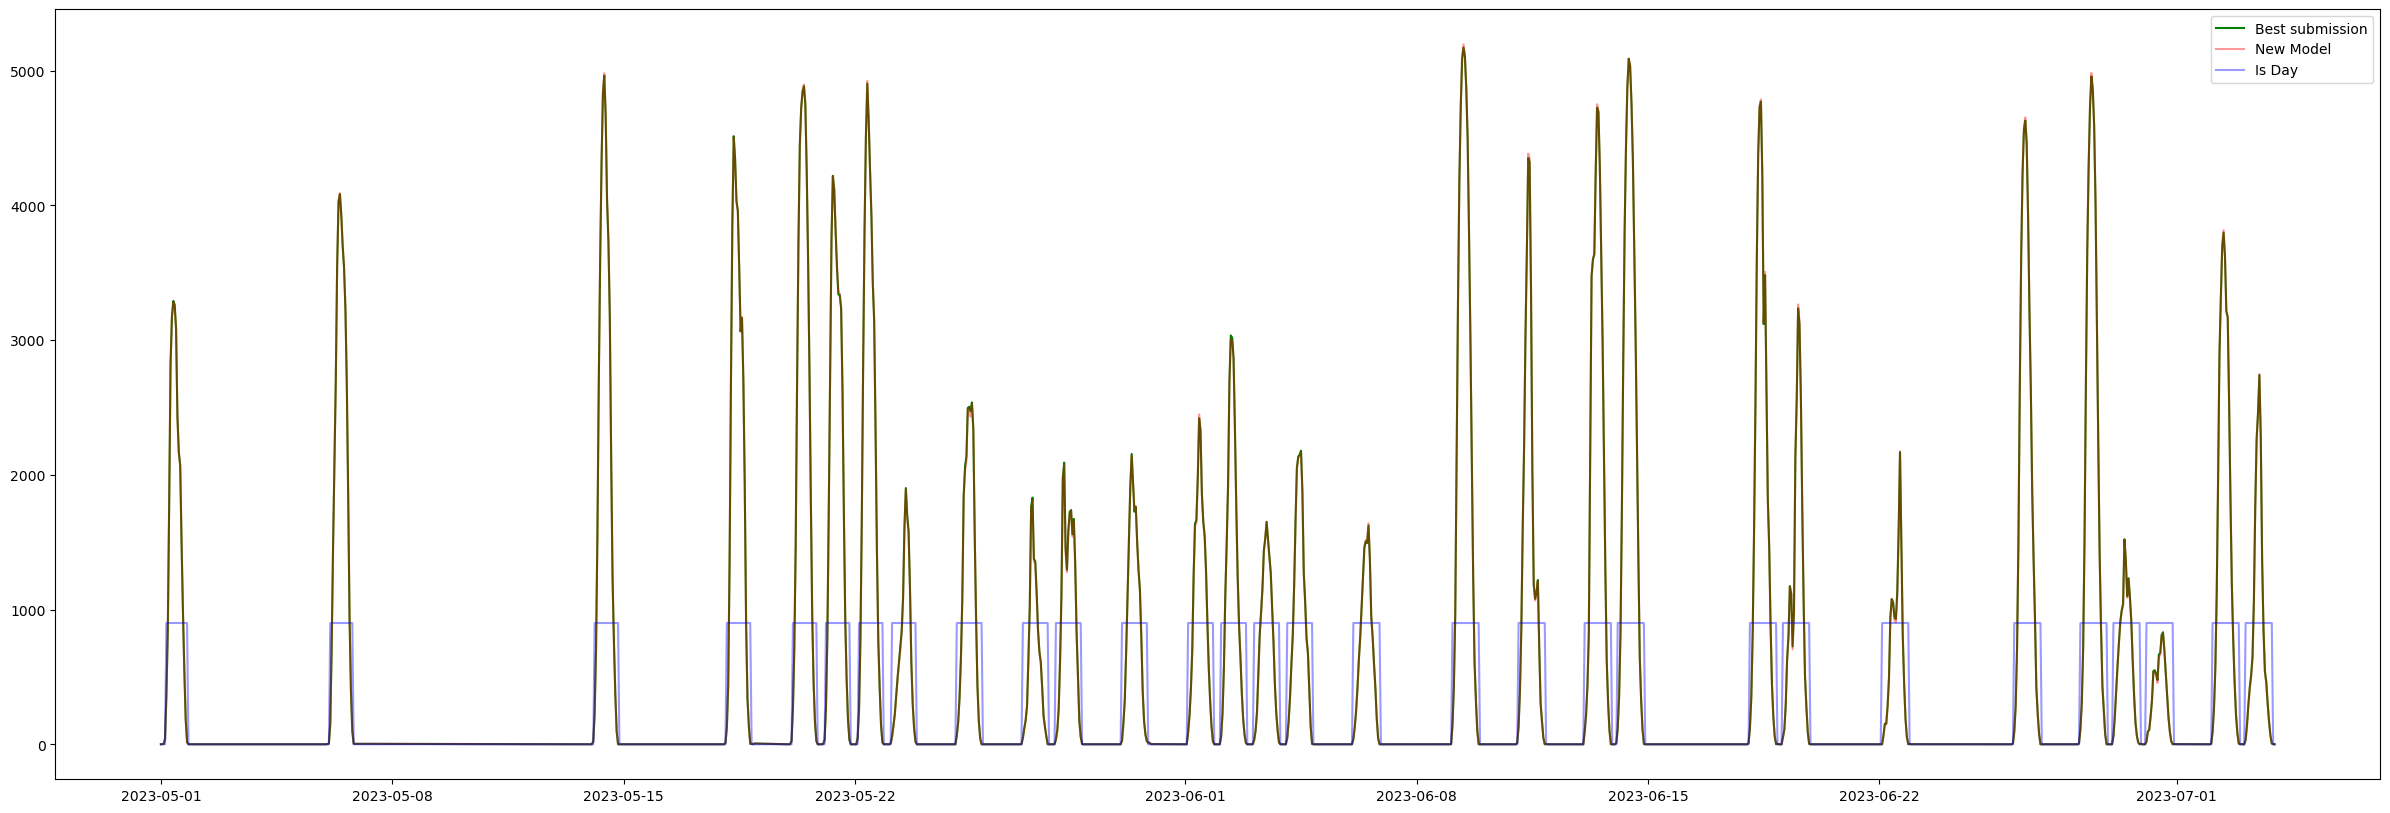

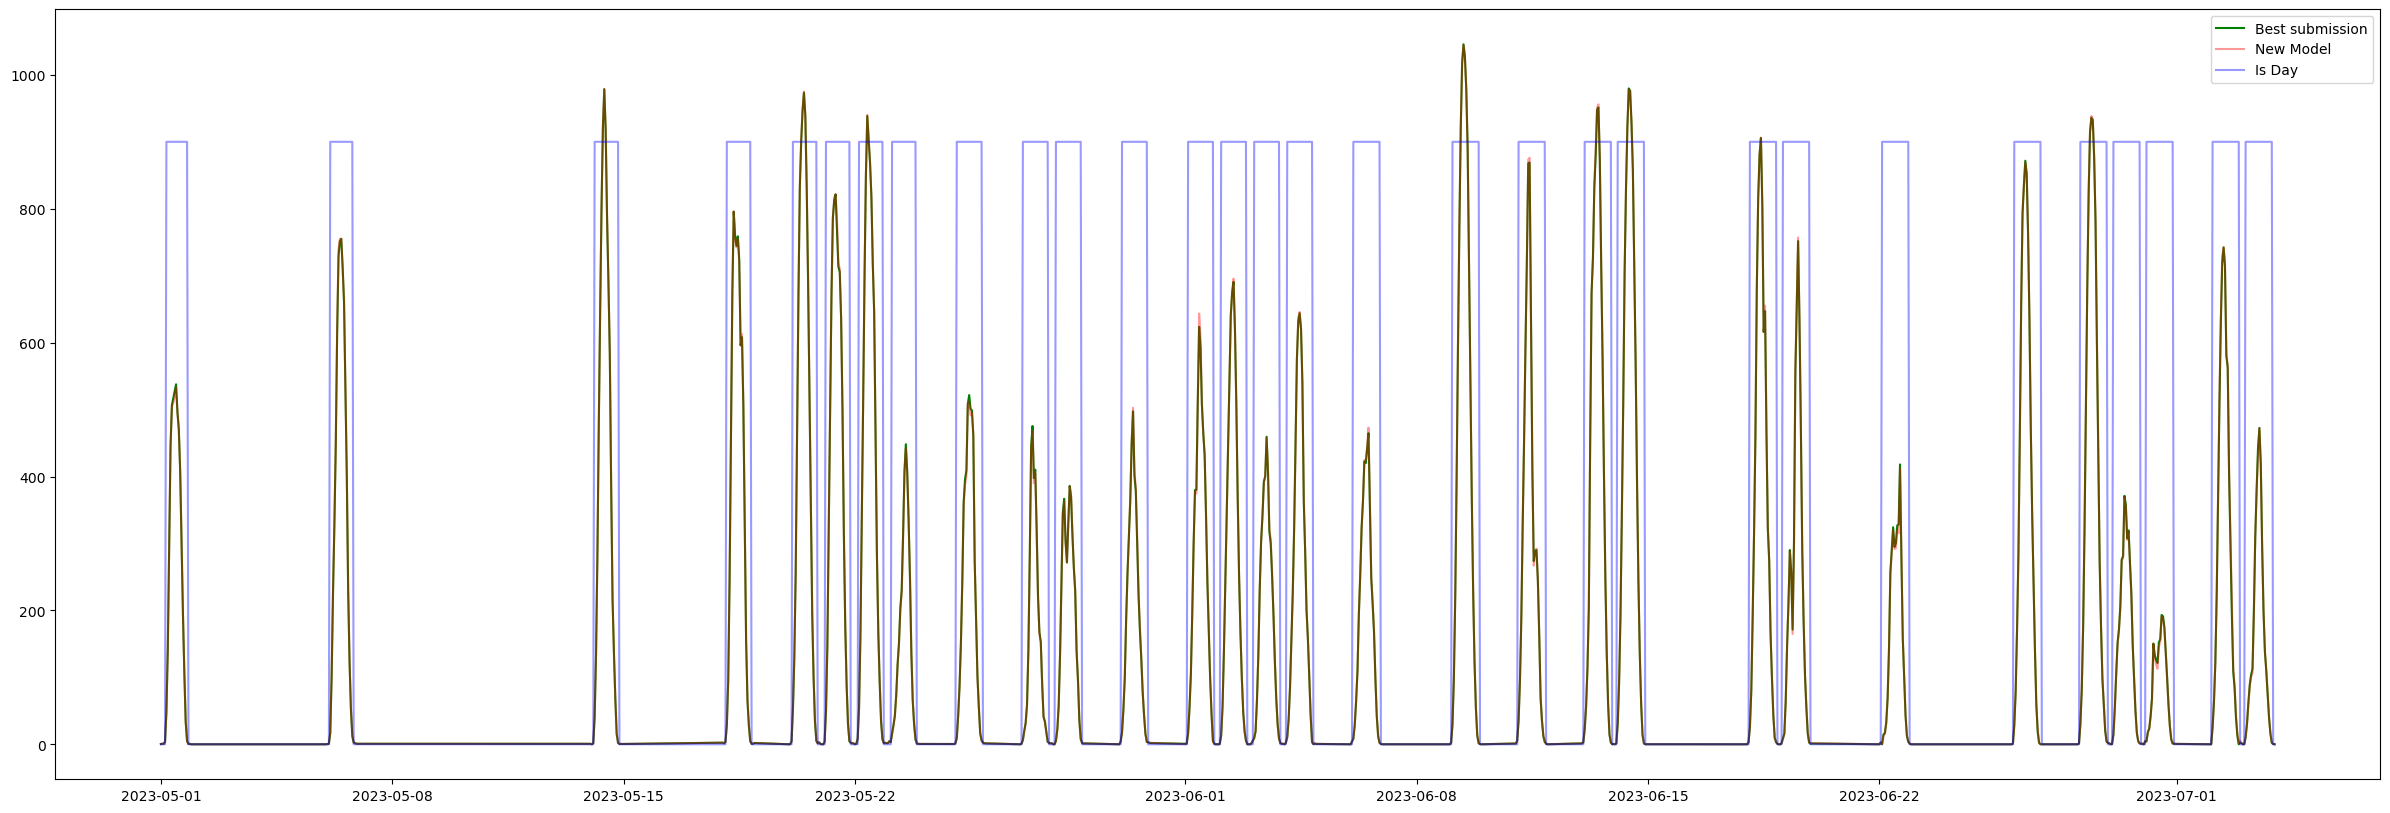

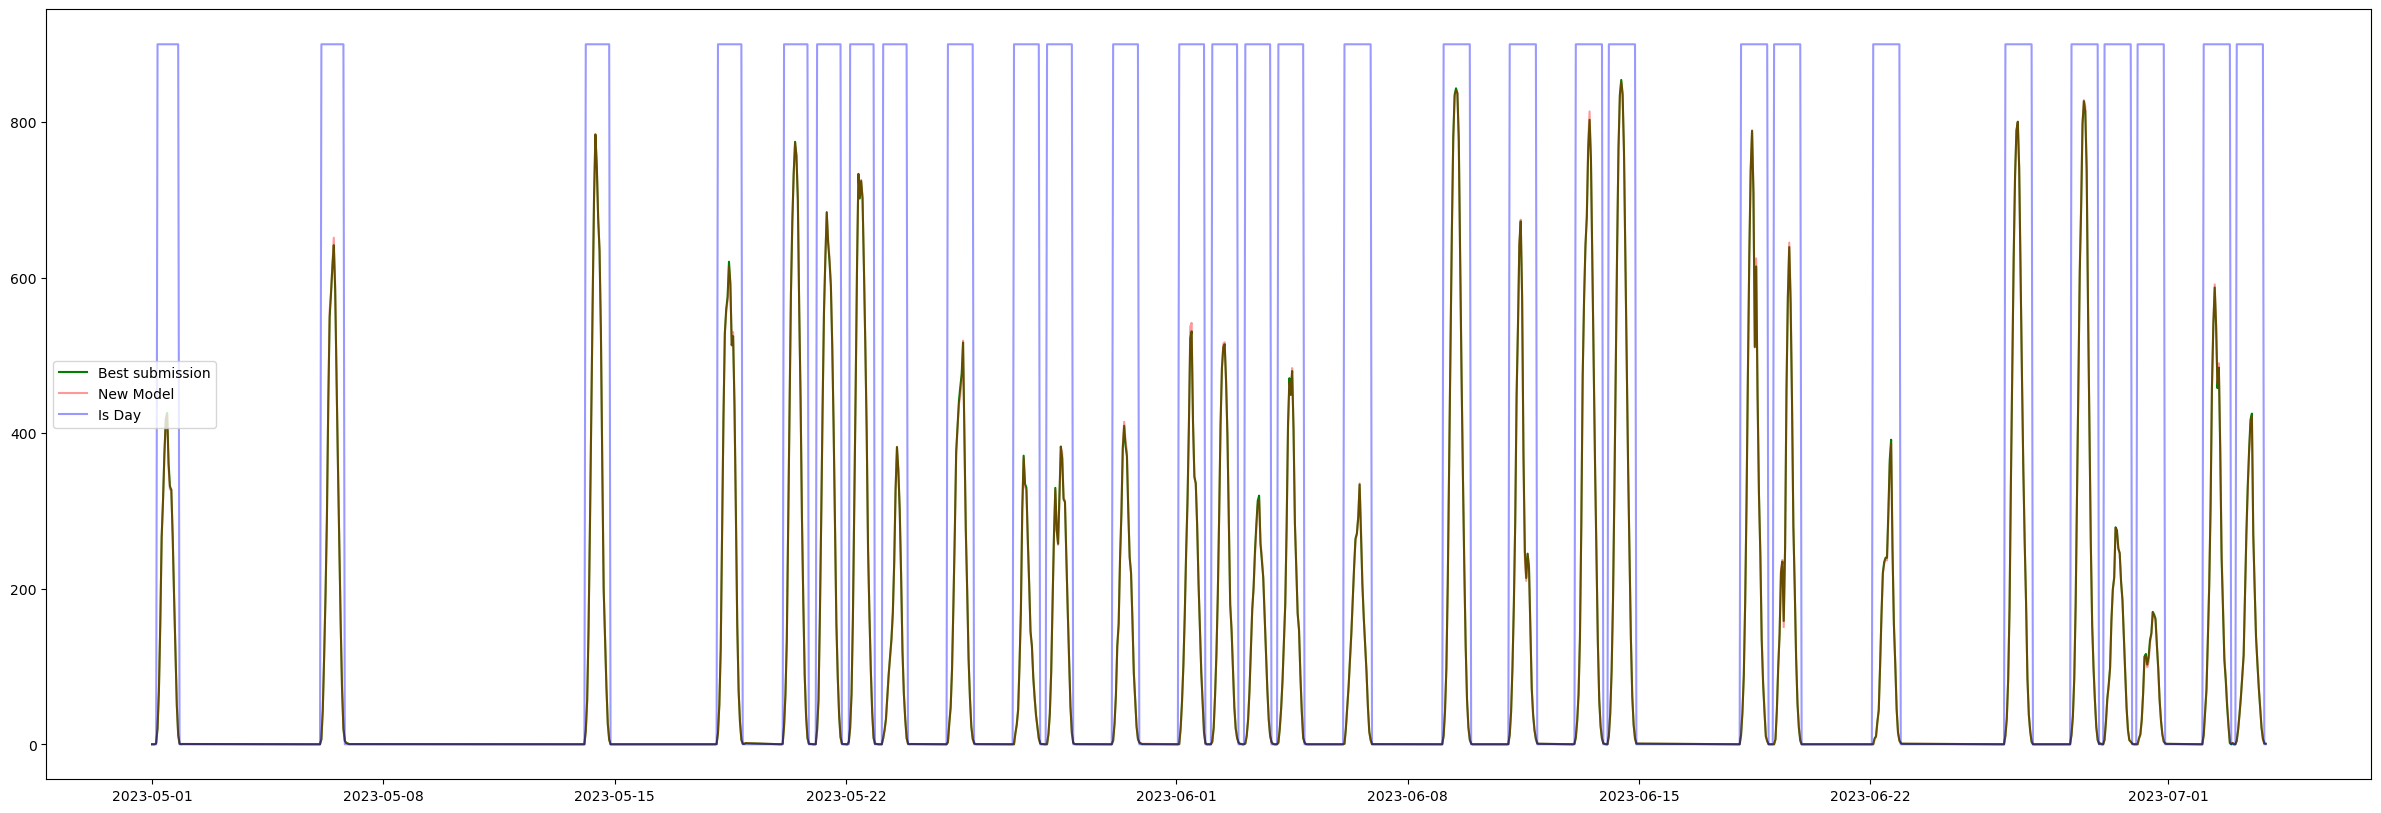

In [1360]:
for location in ("A", "B", "C"):
    plot_ensamble = data[(data.data_type == "test")].sort_values(["location", "date_forecast"]).reset_index(drop=True)
    plot_ensamble = plot_ensamble[plot_ensamble.location == location].index
    plot_ensamble = ensamble[plot_ensamble]

    plt.figure(figsize=(30, 10))
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        best_submission[best_submission.location == location]["prediction"],
        label="Best submission",
        color="green"
    )
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        plot_ensamble,
        label="New Model",
        alpha=0.4,
        color="red"
    )
    plt.plot(
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["date_forecast"],
        data[(data.data_type == "test") & (data.location == location)].sort_values(
            ["date_forecast", "location"]
        )["is_day:idx"] * 900,
        label="Is Day",
        alpha=0.4,
        color="blue"
    )
    plt.legend()

In [801]:
# Potentially saved MAE by post-prosessing
np.sum(
    ensamble
    - np.where(
        (
            data[data.data_type.isin(["test"])].sort_values(
                ["location", "date_forecast"]
            )["is_day:idx"]
        )
        != 0,
        ensamble,
        0,
    )
) / 2160

0.26154175207329444

In [708]:
output_df = pd.DataFrame(ensamble, columns=["prediction"])
output_df = output_df.reset_index(names="id")
output_df.to_csv(
    "../data/results/" + str(datetime.datetime.now()) + "-ensamble.csv", index=False
)